# Building a chatbot on UCF FAQ data by fine-tuning GPT2 model
### Installing accelerate and Parameter efficient fine-tuning library

In [1]:
!pip install --upgrade accelerate
!pip install peft
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00


### Importing necessary packages

In [2]:
# we upgraded `accelerate` just because to import Trainer API
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_config, get_peft_model, PeftModel, PeftConfig, LoraConfig, TaskType
from glob import glob
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

2024-03-28 21:50:46.143034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 21:50:46.143164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 21:50:46.263383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Initializing global constant variables

In [3]:
MODEL_NAME = "gpt2"
DATASET_NAME = "/kaggle/input/faq-ucf/faqsUcfDataset.csv"
SPLIT = 0.2
MAX_LENGTH = 128
EPOCHS = 150

### Defining a DataPreprocessor class that will:
#### 1. Load dataset
#### 2. Preprocess the dataset
#### 3. Initialize an AutoTokenizer and use it to tokenize the dataset
#### 4. Include labels to the dataset

In [4]:
class DataPreprocessor:
    def __init__(self, model_name, max_length):
        # Initialize the DataPreprocessor with the specified model name and max_length
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.tokenizer.pad_token = "<pad>"
    
    def load_dataset(self, dataset_name, split):
        # Load the dataset using the specified split
        try:
            print(f"Loading {dataset_name} dataset...")
            df = pd.read_csv(dataset_name)
            train_ds, validation_ds = train_test_split(df, test_size=SPLIT)
            train_ds = train_ds.reset_index()
            validation_ds = validation_ds.reset_index()
            print(f"Loaded {dataset_name} dataset.")
            return train_ds, validation_ds
        except Exception as e:
            print(f"Error loading dataset: {e}")
            return None, None
    
    def preprocess(self, dataset):
        print("Preprocessing dataset...")
        try:
            # Preprocess the dataset by combining question and answer text
            dataset["text"] = dataset["Q"] + " " + dataset["A"]
            # Drop original columns
            preprocessed_dataset = dataset.drop(['Q', 'A'], axis=1)
            print("Dataset preprocessing completed.")
            return preprocessed_dataset
        except Exception as e:
            print(f"Error preprocessing dataset: {e}")
            return None
    
    def tokenize(self, dataset):
        # Tokenize the dataset
        print("Tokenizing dataset...")
        def tokenize_function(examples):
            return self.tokenizer(examples["text"], max_length=self.max_length, truncation=True, padding="max_length")
        
        try:
            tokenized_dataset = dataset.apply(tokenize_function, axis=1)
            print("Dataset tokenization completed.")
            return tokenized_dataset
        except Exception as e:
            print(f"Error tokenizing dataset: {e}")
            return None
    
    def add_labels(self, dataset):
        # Add labels to the dataset
        print("Adding labels to dataset...")
        def copy_input_ids(example):
            example["labels"] = example["input_ids"].copy()
            return example
        
        try:
            labeled_dataset = dataset.apply(copy_input_ids)
            print("Labels added to dataset.")
            return labeled_dataset
        except Exception as e:
            print(f"Error adding labels to dataset: {e}")
            return None
    
    def preprocess_pipeline(self, dataset_name, split):
        # Execute the preprocessing pipeline
        train_ds, validation_ds = self.load_dataset(dataset_name, split)
        if train_ds is None or validation_ds is None:
            # Dataset loading failed, return None
            print("Preprocessing pipeline aborted due to dataset loading error.")
            return None, None
        
        train_ds = self.preprocess(train_ds)
        validation_ds = self.preprocess(validation_ds)
        if train_ds is None or validation_ds is None:
            # Dataset preprocessing failed, return None
            print("Preprocessing pipeline aborted due to dataset preprocessing error.")
            return None, None
        
        train_ds = self.tokenize(train_ds)
        validation_ds = self.tokenize(validation_ds)
        if train_ds is None or validation_ds is None:
            # Dataset tokenization failed, return None
            print("Preprocessing pipeline aborted due to dataset tokenization error.")
            return None, None
        
        train_ds = self.add_labels(train_ds)
        validation_ds = self.add_labels(validation_ds)
        if train_ds is None or validation_ds is None:
            # Adding labels failed, return None
            print("Preprocessing pipeline aborted due to label addition error.")
            return None, None
        
        return train_ds, validation_ds

### Initializing a DataPreprocessor object and using it to load and preprocess UCF_FAQ dataset

In [5]:
# DataPreprocessor instance
preprocessor = DataPreprocessor(MODEL_NAME, MAX_LENGTH)
# Obtaining train, val datasets and tokenizing them
tokenized_train_ds, tokenized_validation_ds = preprocessor.preprocess_pipeline(DATASET_NAME, SPLIT)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading /kaggle/input/faq-ucf/faqsUcfDataset.csv dataset...
Loaded /kaggle/input/faq-ucf/faqsUcfDataset.csv dataset.
Preprocessing dataset...
Dataset preprocessing completed.
Preprocessing dataset...
Dataset preprocessing completed.
Tokenizing dataset...
Dataset tokenization completed.
Tokenizing dataset...
Dataset tokenization completed.
Adding labels to dataset...
Labels added to dataset.
Adding labels to dataset...
Labels added to dataset.


### Initializing pretrained GPT2 model

In [6]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Initializing Low Rank Adaptation configurations
### Advantages of using LoRA :
### - Trainable parameter reduction -> Less data is required for fine-tuning
### - Faster training
### - Uses less memory
### - PEFT library makes it look so easy!

In [7]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # task_type, token classification (TaskType.CAUSAL_LM)
    inference_mode=False,
    r=8,                           # r, the dimension of the low-rank matrices
    lora_alpha=16,                 # lora_alpha, scaling factor for the weight matrices
    lora_dropout=0.3,              # lora_dropout, dropout probability of the LoRA layers
    fan_in_fan_out=True,
    bias="lora_only"               # bias, set to only lora layers to train
    
)

### Converting our pretrained GPT2 model to lora_model

In [8]:
# Converting our model to lora
lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

trainable params: 322,560 || all params: 124,734,720 || trainable%: 0.2585968044823446


### Initializing training arguments for fine-tuning job

In [9]:
training_args = TrainingArguments(
    "gpt2-on-ucf-faq",
    # Number of epochs to train
    num_train_epochs=EPOCHS,
    # Training batch size
    per_device_train_batch_size=32,
    # Validation batch size
    per_device_eval_batch_size=32,
    # Number of parallel workers
    dataloader_num_workers=2,

    #Evaluating our model after each epoch
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy="epoch",

    learning_rate=1e-3,
    weight_decay=0.01,
    save_total_limit=10,
    report_to='none',

    # Enabling the model to rollback to best checkpoint
    load_best_model_at_end=True,
)

### Defining compute_metric function to calculate perplexity of our model after every epoch

In [10]:
def compute_metrics(pred):
    logits = torch.from_numpy(pred.predictions)
    labels = torch.from_numpy(pred.label_ids)
    loss = F.cross_entropy(logits.view(-1, preprocessor.tokenizer.vocab_size), labels.view(-1))
    return {'perplexity': torch.exp(loss), 'calculated_loss': loss}

### Building a trainer object on our model and training_arguments

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_validation_ds,
    compute_metrics=compute_metrics
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Training/Fine-tuning our lora-gpt2 model on UCF_FAQ dataset

In [12]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
train_output = trainer.train()
print(train_output)

Epoch,Training Loss,Validation Loss,Perplexity,Calculated Loss,Runtime,Samples Per Second,Steps Per Second
1,3.759600,2.190935,404.705841,6.003160,3.287900,22.811000,0.912000
2,2.242400,2.059571,604.482178,6.404372,3.260300,23.004000,0.920000
3,2.075900,1.989849,634.426575,6.452722,3.269300,22.941000,0.918000
4,2.008000,1.956010,611.112366,6.415281,3.455500,21.704000,0.868000
5,1.963400,1.935475,610.293762,6.413940,3.178700,23.594000,0.944000
6,1.919500,1.916508,631.138306,6.447525,3.389700,22.126000,0.885000
7,1.935900,1.902865,643.972595,6.467656,3.169900,23.660000,0.946000
8,1.918100,1.887476,670.147461,6.507498,3.174000,23.629000,0.945000
9,1.882000,1.875736,686.025146,6.530914,3.171800,23.646000,0.946000
10,1.853300,1.866569,724.129639,6.584970,3.285700,22.826000,0.913000


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=1500, training_loss=1.2644926935831706, metrics={'train_runtime': 1372.1118, 'train_samples_per_second': 32.578, 'train_steps_per_second': 1.093, 'total_flos': 2930062668595200.0, 'train_loss': 1.2644926935831706, 'epoch': 150.0})


In [13]:
train_history = pd.DataFrame(trainer.state.log_history)

In [14]:
train_history = train_history.groupby(train_history.index // 2).agg('sum')
train_history.drop(train_history.tail(1).index,inplace=True)

In [15]:
train_history

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_perplexity,eval_calculated_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.7596,0.860105,0.000993,2.0,20,2.190935,404.705841,6.003160,3.2879,22.811,0.912,0.0,0.0,0.0,0.0,0.0
1,2.2424,0.379120,0.000987,4.0,40,2.059571,604.482178,6.404372,3.2603,23.004,0.920,0.0,0.0,0.0,0.0,0.0
2,2.0759,0.320111,0.000980,6.0,60,1.989849,634.426575,6.452722,3.2693,22.941,0.918,0.0,0.0,0.0,0.0,0.0
3,2.0080,0.288571,0.000973,8.0,80,1.956010,611.112366,6.415281,3.4555,21.704,0.868,0.0,0.0,0.0,0.0,0.0
4,1.9634,0.241959,0.000967,10.0,100,1.935475,610.293762,6.413940,3.1787,23.594,0.944,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.9680,1.023700,0.000027,292.0,2920,1.768585,5676.730469,8.644131,3.2279,23.235,0.929,0.0,0.0,0.0,0.0,0.0
146,0.9813,1.075125,0.000020,294.0,2940,1.769390,5696.215332,8.647557,3.3325,22.506,0.900,0.0,0.0,0.0,0.0,0.0
147,0.9858,1.104508,0.000013,296.0,2960,1.770324,5728.689941,8.653242,3.2332,23.197,0.928,0.0,0.0,0.0,0.0,0.0
148,0.9575,0.999637,0.000007,298.0,2980,1.770733,5742.802246,8.655703,3.2901,22.796,0.912,0.0,0.0,0.0,0.0,0.0


In [16]:
def plot_model_hist(history):
    # Plotting train and validation loss graph
    plt.title('Loss')
    #plt.yticks(np.arange(history['loss'].min(), history['loss'].max(), step=(history['loss'].max() - history['loss'].min() // 10)))
    plt.plot(history['loss'], label='train')
    plt.plot(history['eval_loss'],
    label='test')
    plt.legend()
    plt.savefig('loss_graph.png')
    plt.show()

    # Plotting train and validation F1 score graph
    plt.title('Perplexity score')
    plt.plot(history['eval_perplexity'],
    label='test')
    plt.legend()
    plt.savefig('perplexity.png')
    plt.show()

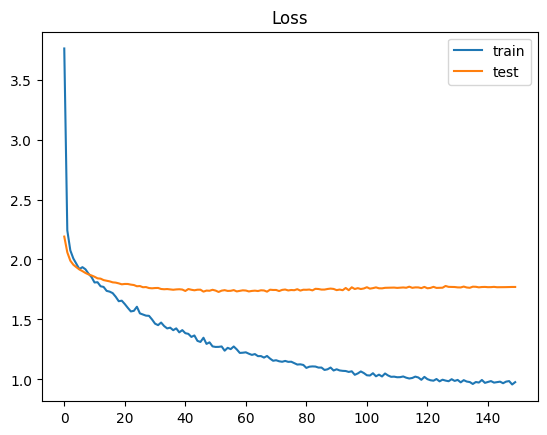

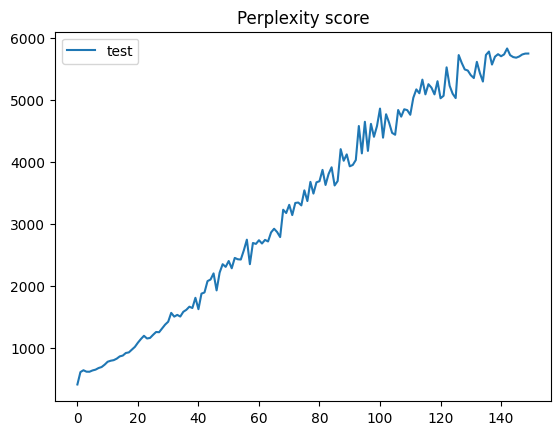

In [17]:
plot_model_hist(train_history)

## Inference

In [21]:
# Create a test prompt
prompt = "How long does it take for an electronic transcript to arrive at UCF?"
# Encode the prompt
encoded_prompt = preprocessor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids
# Transform the encoded representation to the device the model was trained on
encoded_prompt = encoded_prompt.to(trainer.model.device)

# Generating a prediction
output_sequences = trainer.model.generate(
    input_ids=encoded_prompt,
    # Maximum length of predicted sequence
    max_length=MAX_LENGTH,
    min_length=1,
    # Temperature determines how creative/random or strict the model should be
    temperature=.9,
    # Determines the probability sum of tokens that should be kept
    top_p=.95,
    do_sample=True,
    # Predict 3 sequences
    num_return_sequences=3,
    pad_token_id=preprocessor.tokenizer.pad_token_id,
)

generated_sequences = []

# Decoding the predicted sequences
for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
    generated_sequence = generated_sequence.tolist()
    text = preprocessor.tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True, skip_special_tokens=True)
    generated_sequences.append(text.strip().split('?')[1])


Object `UCF` not found.


In [19]:
generated_sequences

[' The transit service typically takes approximately five to seven business days from the receipt of your transcript. When accepted as a formal transcript, the transcript can arrive at UCF within five business days after being received from UCF. Electronic transcripts usually arrive within seven business days after being received from your institution of higher education, so it is important that you complete all required academic and postsecondary transcripts before you can submit them for publication. A transit transcript can take up to three business days to be processed after being received from your institution of higher education.',
 ' Electronic transcripts typically take six to seven business days to arrive at UCF. A transit service usually takes approximately 15-20 business days for transit services.',
 ' Generally speaking, approximately one quarter of a second for a completed transcript to arrive at UCF is considered the average of the following delivery times: After 2:00 P.M

## Running our chatbot

In [22]:
import time 

# Lists to store evaluation metrics
response_lengths = []
response_times = []
user_satisfaction = []

while True:
    prompt = input("User > ")
    if prompt:
        if prompt == "bye":
            break
        encoded_prompt = preprocessor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids
        encoded_prompt = encoded_prompt.to(trainer.model.device)

        # Record start time
        start_time = time.time()

        # prediction
        output_sequences = trainer.model.generate(
            input_ids=encoded_prompt,
            max_length=MAX_LENGTH,
            min_length=1,
            temperature=.9,
            top_p=.95,
            do_sample=True,
            num_return_sequences=1,
            pad_token_id=preprocessor.tokenizer.pad_token_id,
        )
        # Record end time
        end_time = time.time()
        
        generated_sequences = []

        
        # decode prediction
        for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
            generated_sequence = generated_sequence.tolist()
            text = preprocessor.tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True, skip_special_tokens=True)
            generated_sequences.append(text.strip().split("?")[1])
        print("Assistant > ", generated_sequences[0])
        
        ### For evaluation metrics
        
        # Calculate response time
        response_time = end_time - start_time
        response_times.append(response_time)

        # Calculate response length
        response_length = len(generated_sequences[0])
        response_lengths.append(response_length)
        

User >  How long does it take for an electronic transcript to arrive at UCF?


Assistant >   Electronic transcripts typically arrive at UCF within five to seven business days after being sent from the school. Most electronic transcripts are received within two to six business days after being sent from the school. All academic transcript requests must be received by October 1. All electronic transcripts must be received by December 1 for approval by the Registrar’s Office. Transit transcripts, usually obtained within five business days after being sent from the school, usually takes about seven to 10 business days to process. Some applications require a considerable wait time before a final transcript can be received, so please be


User >  Assistant


Assistant >   When you request a fellowship of postgraduate study, you must go through the Office of Graduate Student Financial Assistance (OGFS). Once you get there, complete the Post Graduate Fellowship Application form. Once you have completed it, enter your full name and email address in the field that says Academic Affiliation.


User >  Assistant


Assistant >   In addition to the scholarship, you will receive a $300 student-submitted fellowship upon your arrival in our campus. You will be placed on an Open Seat fellowship that is $35 per semester. To receive a fellowship, please visit the Fellowships page at www.ucf.edu/fellowships/open-seat.


User >  bye


# **Evaluation Metrics**

In [23]:
import matplotlib.pyplot as plt


# Print and plot evaluation metrics
print("Response Time:", response_time)
print("Response Length:", response_length)

Response Time: 1.0003070831298828
Response Length: 287


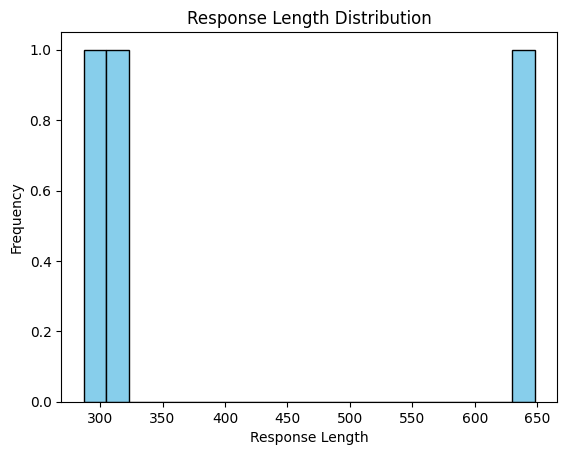

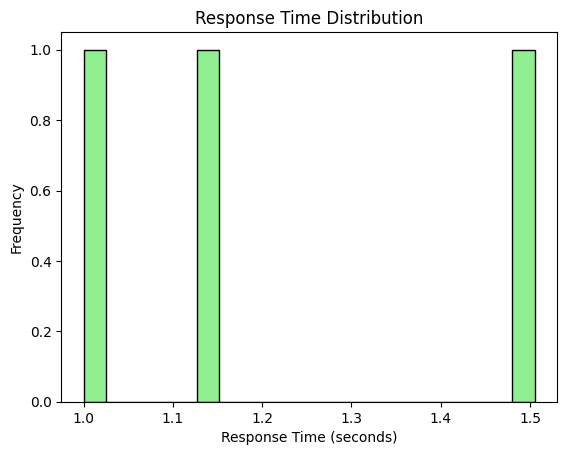

In [24]:
# Plot response length distribution
plt.hist(response_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Response Length Distribution')
plt.xlabel('Response Length')
plt.ylabel('Frequency')
plt.show()

# Plot response time distribution
plt.hist(response_times, bins=20, color='lightgreen', edgecolor='black')
plt.title('Response Time Distribution')
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.show()


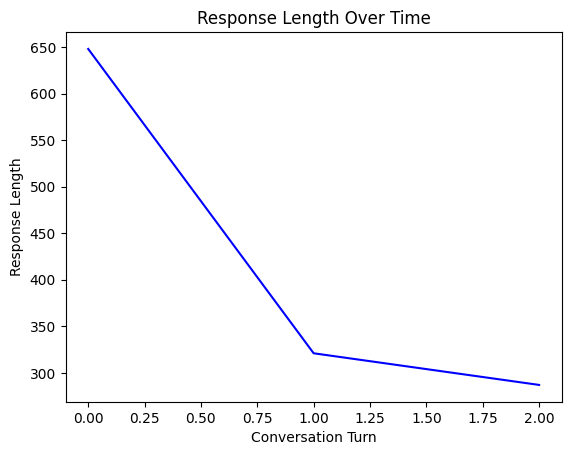

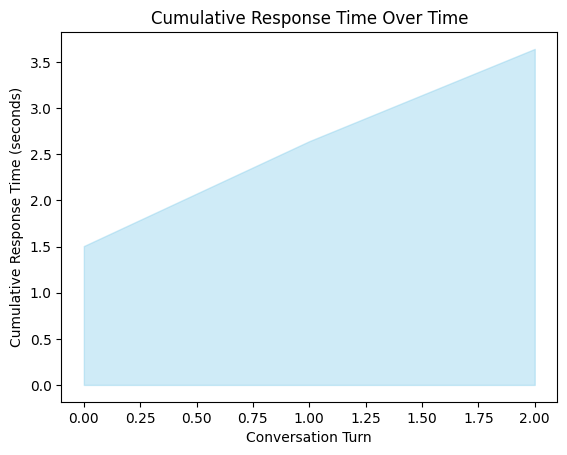

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


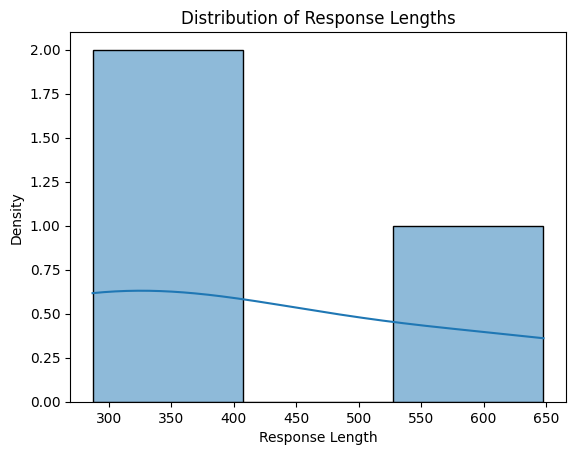

In [25]:
import seaborn as sns

# Line Plot: Response length over time
plt.plot(range(len(response_lengths)), response_lengths, color='blue')
plt.title('Response Length Over Time')
plt.xlabel('Conversation Turn')
plt.ylabel('Response Length')
plt.show()

# Stacked Area Chart: Cumulative response time over time
cumulative_response_times = [sum(response_times[:i+1]) for i in range(len(response_times))]
plt.fill_between(range(len(cumulative_response_times)), cumulative_response_times, color='skyblue', alpha=0.4)
plt.title('Cumulative Response Time Over Time')
plt.xlabel('Conversation Turn')
plt.ylabel('Cumulative Response Time (seconds)')
plt.show()

# Histogram with Density Plot: Distribution of response lengths with density plot
sns.histplot(response_lengths, kde=True)
plt.title('Distribution of Response Lengths')
plt.xlabel('Response Length')
plt.ylabel('Density')
plt.show()